## Two electrons in a well

Now that's been quite a slog to get through all that theory, it'll be nice to bring the equations to life by actually running iDEA. We'll focus on the physics going on and won't worry too much about how iDEA is solving the equations under the hood.

### Defining the external potential

We start by investigating the electronic ground state of two electrons sitting in a harmonic well.
Let's define our external potential $V_{ext}(r)$.

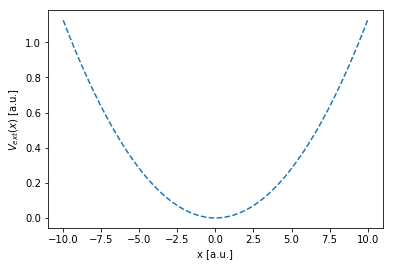

In [1]:
# Let's define our external potential
omega = 0.15   # resonance frequency in atomic units
def harmonic_well(x):
    return 1/2 * omega**2 * x**2

# and plot it
import numpy as np
x = np.linspace(-10,10,100)

import matplotlib.pyplot as plt
plt.plot(x, harmonic_well(x), '--')
plt.xlabel("x [a.u.]")
plt.ylabel(r"$V_{ext}(x)$ [a.u.]")
plt.show()

### Computing the ground state
Now we'll fill $N=2$ electrons into the system and use the iDEA code to find the exact solution to the time-independent Schrödinger equation

$$\left(-\frac{1}{2} \sum_i \frac{\partial^2}{\partial r_i^2} + V_{ext}(r_i) + \frac{1}{2}\sum_{i\neq j}v(r_i-r_j) \right) \Psi(r_1,r_2) = E \Psi(r_1,r_2)$$


In [2]:
from iDEA.input import Input
pm = Input()   # create input parameters with default settings
pm.sys.NE = 2  # we want 2 electrons
pm.sys.v_ext = harmonic_well  # pass on our external potential

print(pm.sys)  # show all system parameters

pm.run.name = "harmonic_well"
pm.run.EXT  = True     # run the exact system
pm.run.LDA  = True     # run DFT in the local density approximation
pm.run.NON  = True     # run the non-interacting approximation

print(pm.sys)  # show all run parameters

NE = 2
grid = 201
stencil = 3
xmax = 10.0
tmax = 1.0
imax = 1001
acon = 1.0
interaction_strength = 1.0
im = 0
v_ext = <function harmonic_well at 0x10c942ae8>
v_pert = <function Input.__init__.<locals>.v_pert at 0x114d5dae8>
v_pert_im = <function Input.__init__.<locals>.v_pert_im at 0x114d321e0>

NE = 2
grid = 201
stencil = 3
xmax = 10.0
tmax = 1.0
imax = 1001
acon = 1.0
interaction_strength = 1.0
im = 0
v_ext = <function harmonic_well at 0x10c942ae8>
v_pert = <function Input.__init__.<locals>.v_pert at 0x114d5dae8>
v_pert_im = <function Input.__init__.<locals>.v_pert_im at 0x114d321e0>



We're going to compute the ground state both exactly and in the non-interacting and local-density approximations. Let's go!

In [3]:
# run iDEA with specified parameters and save results
# this shouldn't take more than a minute
results = pm.execute()  

                                                              
                *    ****     *****       *                   
                     *   *    *          * *                  
                *    *    *   *         *   *                 
                *    *     *  *****    *     *                
                *    *    *   *       *********               
                *    *   *    *      *         *              
                *    ****     ***** *           *             
                                                              
  +----------------------------------------------------------+
  |          Interacting Dynamic Electrons Approach          |
  |              to Many-Body Quantum Mechanics              |
  |                                                          |
  |                      Release 2.2.0                       |
  |                                                          |
  |       Created by Piers Lillystone, James Ramsden,  

Given $\Psi(r_1,r_2)$, we can compute the corresponding density $n(r)$ - in fact, iDEA has already done it for us.

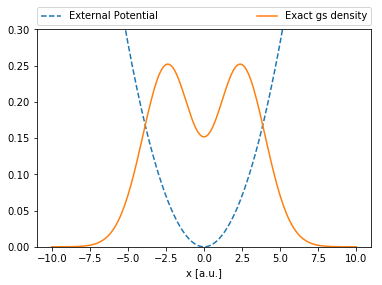

In [4]:
x = pm.space.grid
plt.plot(x,results.ext.gs_ext_vxt,'--', label = "External Potential")
plt.plot(x,results.ext.gs_ext_den, label = "Exact gs density")

plt.xlabel("x [a.u.]")
#plt.xlim([-5,5])
plt.ylim([0,0.3])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

It turns out that for two (spinless) electrons, you get two bumps inside the well.

Let's see how the non-interacting and local-density approximations measure up against the exact solution.

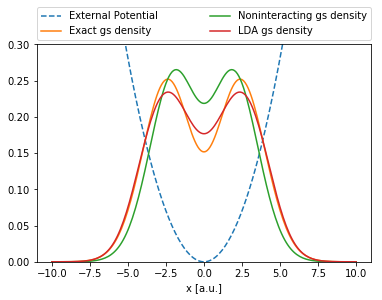

In [5]:
plt.plot(x,results.ext.gs_ext_vxt,'--', label = "External Potential")
plt.plot(x,results.ext.gs_ext_den, label = "Exact gs density")
plt.plot(x,results.non.gs_non_den, label = "Noninteracting gs density")
plt.plot(x,results.lda.gs_lda2_den, label = "LDA gs density")

plt.xlabel("x [a.u.]")
#plt.xlim([-5,5])
plt.ylim([0,0.3])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

This plot illustrates a few interesting things about the theory. 

Firstly we can see that the non-interacting electron approximation gets the rough shape of the density right. However, the electron's are more likely to be found near the centre of the well since they prefer to be in regions of low potential, and don't have Coulomb interaction pushing them away from each other. 

We also see that the LDA does a good job at predicting the *position* of density maxima, while still showing significant deviations in their *values*. 

### Reverse engineering

Now, in Kohn-Sham density functional theory, the task is to find the Kohn-Sham potential $V_{KS}(r)$ such that the solution of the non-interacting Kohn-Sham system

$$\left(-\frac{1}{2} \frac{\partial^2}{\partial r^2}+V_{KS}(r)\right) \psi_i(r) = i \frac{\partial}{\partial t} \psi_i(r)$$

yields the same density as the exact ground state. Since we are lucky enough to already *know* the exact $n(r)$ for our system, this task reduces to an optimisation problem. 

Before we give this problem to iDEA, let's have a go at it ourselves.
Given that the non-interacting electron density (green) is a little higher in the centre of the well than the exact density (red), the Kohn-Sham potential will probably need to add a bump in the centre of the well in order to push the Kohn-Sham electrons away.
<div class="alert alert-success">
Try to optimize the Kohn-Sham potential to bring $n_{KS}(r)$ as close as possible to $n(r)$.
</div>




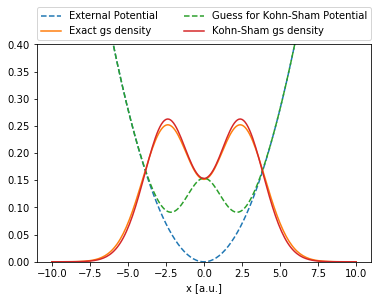

Integrated absolute density difference: 0.080


In [32]:
alpha=0.2   # prefactor of Gaussian bump
sigma=1.3   # width of Gaussian bump
def kohn_sham_guess(x):
    return harmonic_well(x) + alpha / sigma * np.exp( -x**2 / (2*sigma**2))

# now we run the non-interacting system for this Kohn-Sham potential
pm.sys.v_ext = kohn_sham_guess
pm.run.EXT  = False
pm.run.LDA  = False
pm.run.NON  = True
pm.run.verbosity = 'low' # suppress text output
results_non = pm.execute()  # this should be essentially instantaneous

plt.plot(x,results.ext.gs_ext_vxt,'--', label = "External Potential")
plt.plot(x,results.ext.gs_ext_den, label = "Exact gs density")

plt.plot(x,results_non.non.gs_non_vxt,'--', label = "Guess for Kohn-Sham Potential")
plt.plot(x,results_non.non.gs_non_den, label = "Kohn-Sham gs density")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

plt.xlabel("x [a.u.]")
plt.ylim([0,0.4])
plt.show()

# computing the density-difference
den_diff = np.abs(results.ext.gs_ext_den - results_non.non.gs_non_den)
den_err = np.sum(den_diff) * pm.space.delta
print("Integrated absolute density difference: {:.3f}".format(den_err))


If you play around with the Kohn-Sham potential for a while, you will manage to get the solution pretty close to the exact one.

Now let iDEA have a go at finding the Kohn-Sham potential using its reverse engineering algorithm.

In [7]:
# again, this should take less than a minute
pm.run.NON  = False
pm.ext.RE = True     # reverse engineer exact density
results_re = pm.execute()
print("Done")

Done


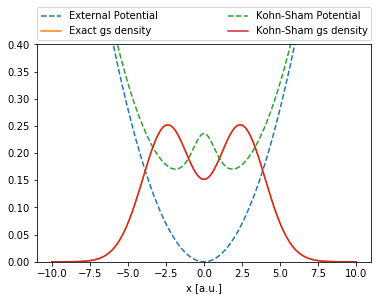

Integrated absolute density difference: 0.0000000001


In [26]:
# re-plotting exact results from before
plt.plot(x,results.ext.gs_ext_vxt,'--', label = "External Potential")
plt.plot(x,results.ext.gs_ext_den, label = "Exact gs density")

# align external and Kohn-Sham potential a the box edge
vks = results_re.extre.gs_extre_vks
vks += results.ext.gs_ext_vxt[0] - vks[0]

# adding results from reverse-engineering
plt.plot(x,vks,'--', label = "Kohn-Sham Potential")
plt.plot(x,results_re.extre.gs_extre_den, label = "Kohn-Sham gs density")

plt.xlabel("x [a.u.]")
plt.ylim([0,0.4])
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

# computing the density-difference
den_diff = np.abs(results.ext.gs_ext_den - results_re.extre.gs_extre_den)
den_err = np.sum(den_diff) * pm.space.delta
print("Integrated absolute density difference: {:.10f}".format(den_err))

If everything has gone right, the exact ground-state and Kohn-Sham density should coincide exactly.

You may notice that even though we have aligned $V_{KS}$ and $V_{ext}$ at the edge of the box, 
**continue from here**